# Perform Ragas Evaluation Learn

In [38]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

evaluator_llm = LangchainLLMWrapper(AzureChatOpenAI(
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME"),
    model="gpt-4o-mini-lke",
    validate_base_url=False
))

# init the embeddings for answer_relevancy, asnwer correctness and answer similarity
evaluator_embeddings = LangchainEmbeddingsWrapper(AzureOpenAIEmbeddings(
            azure_deployment=os.environ.get('TEXT_EMBEDDING_MODEL_DEPLOYMENT'),
            api_key = os.environ.get('AZURE_OPENAI_APIKEY'),
            azure_endpoint = os.environ.get('AZURE_OPENAI_ENDPOINT'),
            model = os.environ.get('TEXT_EMBEDDING_MODEL_NAME')
        ))

In [39]:
from ragas import SingleTurnSample
from ragas.metrics import AspectCritic

test_data = {
    "user_input": "summarise given text\nThe company reported an 8% rise in Q3 2024, driven by strong performance in the Asian market. Sales in this region have significantly contributed to the overall growth. Analysts attribute this success to strategic marketing and product localization. The positive trend in the Asian market is expected to continue into the next quarter.",
    "response": "The company experienced an 8% increase in Q3 2024, largely due to effective marketing strategies and product adaptation, with expectations of continued growth in the coming quarter.",
}

metric = AspectCritic(name="summary_accuracy",llm=evaluator_llm, definition="Verify if the summary is accurate.")
test_data = SingleTurnSample(**test_data)

await metric.single_turn_ascore(test_data)

1

### Answer Semantic Similarity

The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the `ground_truth` and the `answer`, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth. 

Measuring the semantic similarity between answers can offer valuable insights into the quality of the generated response. This evaluation utilises a cross-encoder model to calculate the semantic similarity score. 

In [40]:
from datasets import Dataset 
from ragas.metrics import answer_similarity
from ragas import evaluate


data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on Jan 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'ground_truth': ['The first superbowl was held on January 15, 1967', 'The New England Patriots have won the Super Bowl a record six times']
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[answer_similarity])
score.to_pandas()

Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


,user_input,response,reference,semantic_similarity
0,When was the first super bowl?,"The first superbowl was held on Jan 15, 1967","The first superbowl was held on January 15, 1967",0.996387
1,Who won the most super bowls?,The most super bowls have been won by The New ...,The New England Patriots have won the Super Bo...,0.924290


In [41]:
from ragas.metrics import ResponseRelevancy
from ragas import SingleTurnSample

sample = SingleTurnSample(
        user_input="When was the first super bowl?",
        response="The first superbowl was held on Jan 15, 1967",
        retrieved_contexts=[
            "The First AFL–NFL World Championship Game was an American football game played on January 15, 1967, at the Los Angeles Memorial Coliseum in Los Angeles."
        ]
    )

scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
await scorer.single_turn_ascore(sample)

np.float64(0.9807395004223677)

## RAGAS Metrics
https://wandb.ai/byyoung3/ML_NEWS3/reports/How-to-evaluate-a-Langchain-RAG-system-with-RAGAs--Vmlldzo5NzU1NDYx

### Context precision 
Evaluates how well the system ranks relevant information within the top retrieved documents. It ensures that not only relevant documents are retrieved but that the most useful ones appear at the top. The overall context precision score is calculated by averaging these weighted precision values across the top K results. This metric ensures that users receive the most useful information in the most accessible way. 

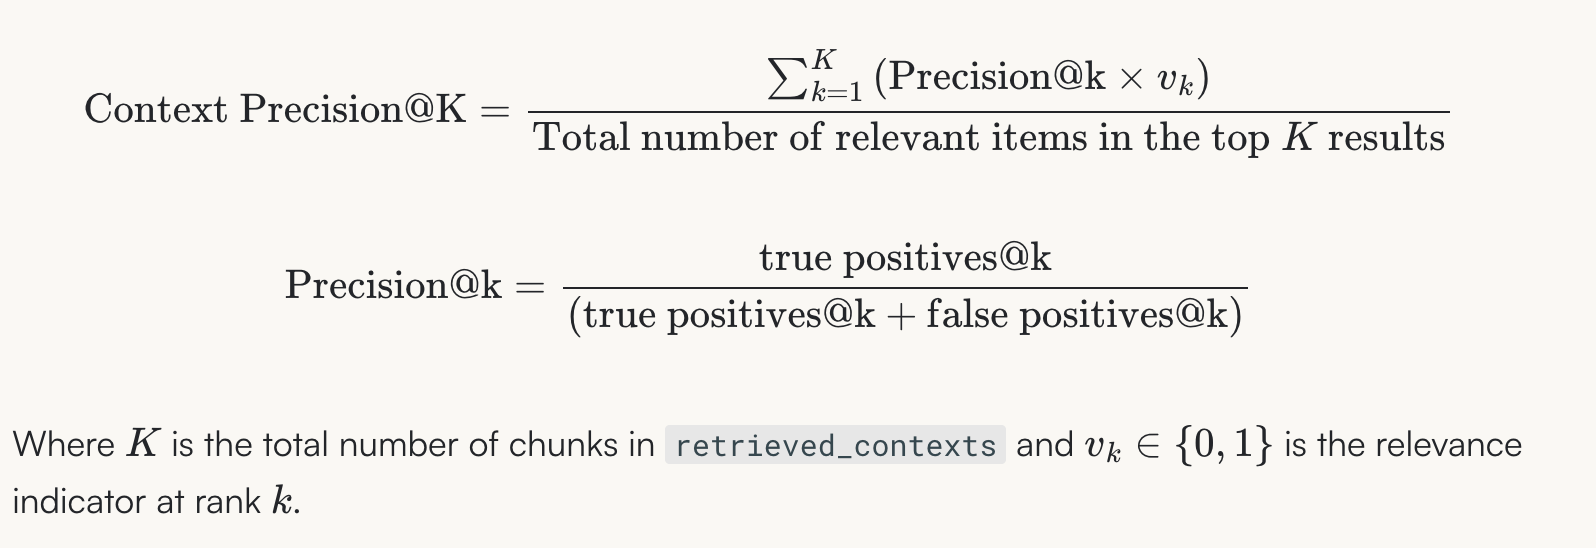

### Context recall
Focuses on ensuring the completeness of the retrieval process. It measures how well the system retrieves all relevant pieces of information needed to answer the query. Using the LLMs, RAGAS breaks down both the retrieved content and the ground truth (GT) reference into individual claims. 

For each GT claim, the system checks whether it can be inferred from the retrieved content. 

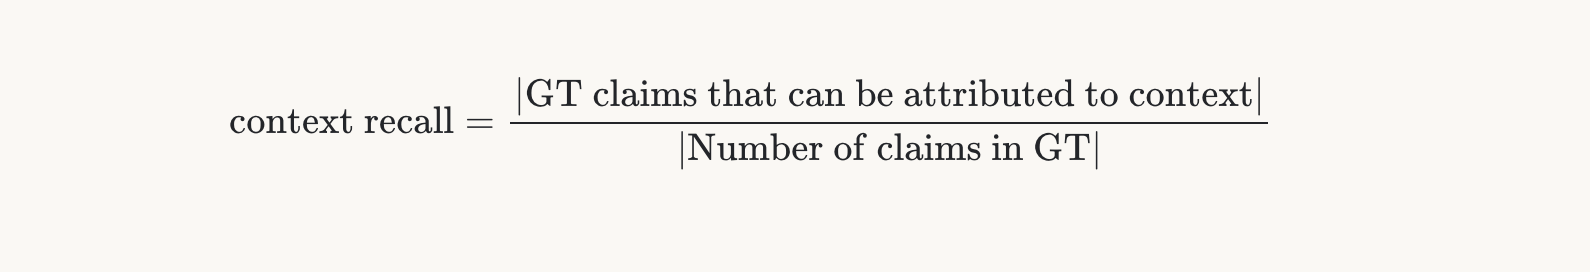

### Response Relevancy
Measures how closely the generated response aligns with the user's query. This metric ensures that the response is meaningful and directly addresses the user's intent without unnecessary information. RAGAS uses LLMs to generate a set of artificial questions from the system's response. 

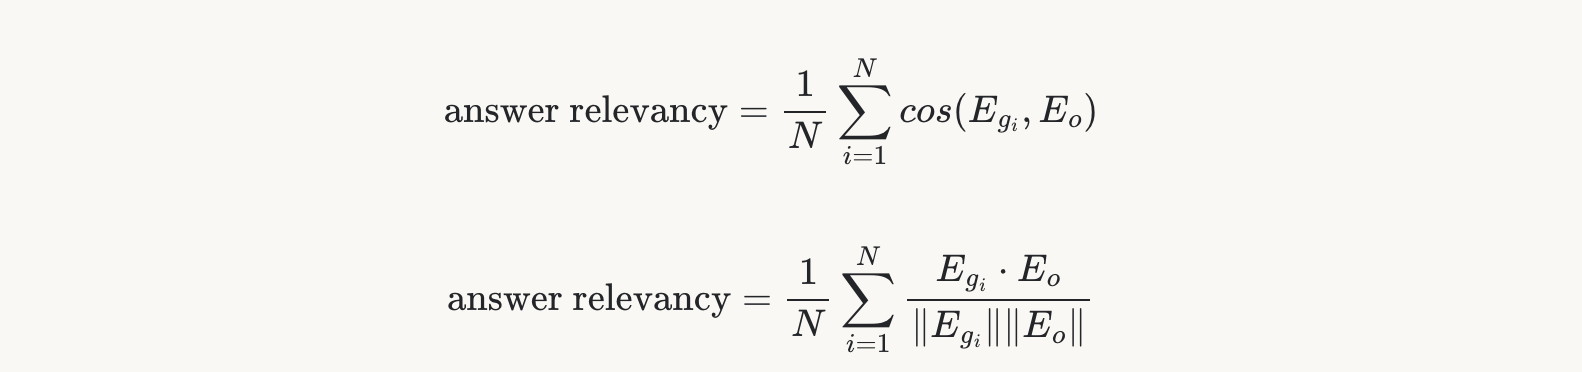

### Faithfulness
Ensures that the generated response remains consistent with the retrieved information and avoids hallucinations or contradictions. RAGAS breaks down the generated response into individual claims using LLMs. Each claim is cross-checked against the retrieved context to determine if it can be inferred from the data. For each claim, the system provides a verdict on whether it is supported by the retrieved context. The faithfulness scores is calculated as the proportion of verified claims to the total number of claims in the response. 

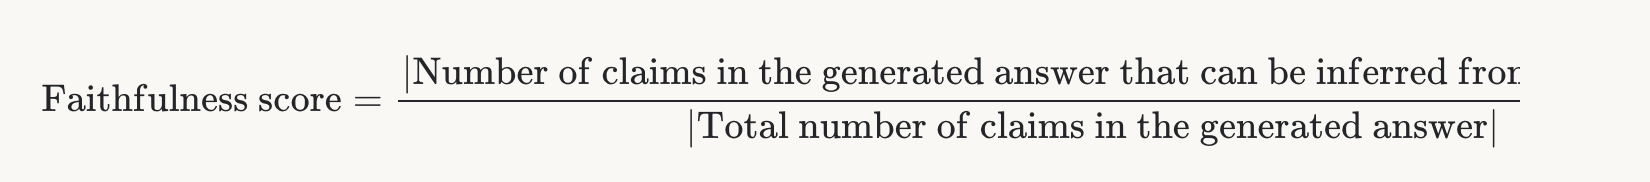

### Noise sensitivity 
Measures how often a system makes errors by generating incorrect responses, whether based on relevant or irrelevant retrieved documents. A lower noise sensitivity score indicates better performance, with values ranging between 0 and 1. 

To calculate this score, the system checks every claim in the generated response against the ground truth to determine whether it is accurate and whether it aligns with the relevant retrieved contexts. 

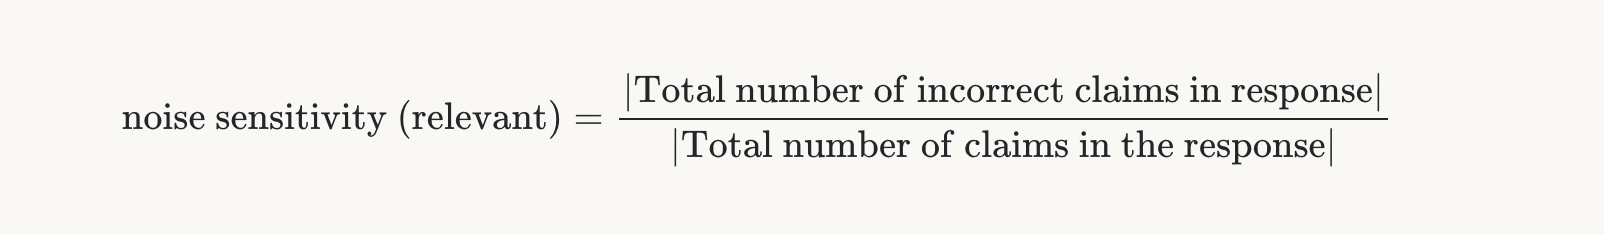

### Factual correctness
Is a metric used to compare and evaluate the factual alignment between a generated response and a reference answer. This metric helps determine how accurately the generated output reflects the intended information. In RAGAS, factual correctness is computed by first breaking down both the response and the reference into individual claims using LLMs. Each claim is then compared to assess how well the generated content matches the refernce. 


In [42]:
import os 
print(os.getcwd())

/Users/keenlim/Final-Year-Project/Development/Course_v2/course_v2


In [43]:
import os 
os.chdir('/Users/keenlim/Final-Year-Project/Development/Course_v2/course_v2/')

In [44]:
# Preprocess to prepare for ragas evaluation

# Load CSV dataset from csv file and transform to json
import pandas as pd 
from functions.workflow.retrieval_workflow import Retrieval_Workflow

# Load the CSV file into a Dataframe
df = pd.read_csv('ragas_eval/testDatasets/RagasDatasets.csv')

# Extract the "query" and "reference" columns
queries = df["query"].tolist()
references = df["reference"].tolist()

response = []
retrieved_context = []

# Process them as needed 
for q, r in zip(queries, references):
    # Start the retrieval workflow for each query and reference pair
    workflow = Retrieval_Workflow().workflow_function()

    generated_answer = workflow.invoke(
            {
                "query": [q],
                "cached_messages": [],
                "user_profile": {"degree": '', "year_standing": "", "semester": ""}
            }
    )

    cur_response = generated_answer["answer"]
    cur_retrieved_context = generated_answer["database_records"]
    
    response.append(cur_response)
    retrieved_context.append(cur_retrieved_context)

df["response"] = response

df["retrieved_context"] = retrieved_context

df.to_csv('ragas_eval/testDatasets/RagasDatasets.csv', index=False)



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: 'MATCH (n:`AURequirement`)\nWITH collect(distinct substring(toString(n.`AUCode`), 0, 50)) AS `AUCode_values`,\

[]
Question: List down the core courses available in DSAI degree programme?

Question: What are the courses I am supposed to take in Year 2 as a DSAI student?

Question: What ICC courses I have to complete as a DSAI student.



KeyboardInterrupt: 

In [56]:
# Ragas Evaluation
# Load CSV dataset from csv file and transform to json
import pandas as pd 
from ragas import SingleTurnSample

# Load the CSV file into a Dataframe
df = pd.read_csv('ragas_eval/testDatasets/RagasDatasets.csv')

# Extract the "query" and "reference" columns
queries = df["query"].tolist()
references = df["reference"].tolist()
responses = df["response"].tolist()
retrieved_contexts = df["retrieved_context"].tolist()

# print(retrieved_contexts)
dataset = []

# Process them as needed 
for query, reference, response, retrieved_context in zip(queries, references, responses, retrieved_contexts):
    data_list = [retrieved_context]
    dataset.append(SingleTurnSample(
            user_input= query, 
            retrieved_contexts=data_list,
            response=response,
            reference=reference       
        )
    )

# print(dataset)



In [57]:
from ragas import EvaluationDataset
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate

evaluation_dataset = EvaluationDataset(samples = dataset)

llm_4o = AzureChatOpenAI(model="ANV2Exp-AzureOpenAI-NorthCtrlUS-TWY-GPT4o", temperature=0)

evaluator_llm = LangchainLLMWrapper(llm_4o)

from ragas.metrics import Faithfulness, FactualCorrectness, ResponseRelevancy, LLMContextRecall

answer_relevancy_result = evaluate(dataset=evaluation_dataset, metrics=[ResponseRelevancy()], llm=evaluator_llm)
answer_relevancy_result


Evaluating: 100%|██████████| 49/49 [03:20<00:00,  4.09s/it]


{'answer_relevancy': 0.8434}

In [58]:
answer_relevancy_result.to_pandas()

,user_input,retrieved_contexts,response,reference,answer_relevancy
0,What courses are offered by the DSAI degree pr...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The courses available in the Bachelor of Compu...,The courses offered by the degree with degreeC...,0.920751
1,List all the prerequisites for the course MH3701.,"[[{'yearReqs': ['Year 3'], 'groupLogic': 'OR',...",The prerequisites for the course 'MH3701' are ...,"Students are required to be Year 3 standing, a...",0.967584
2,Does SC1003 have any prerequisites?,"[[{'c': {'courseCode': 'SC1003', 'academicUnit...",Course Code: SC1003\nTitle: Introduction to Co...,"No, SC1003 have no prerequisites",0.890163
3,Show me the prerequisite details for SC3000.,"[[{'yearReqs': ['Year 3'], 'groupLogic': None,...",The prerequisites for course SC3000 are:\n- Ye...,"Students are required to be Year 3 standing, a...",0.904828
4,Which degrees are offered by the Computer Scie...,"[[{'d.degreeCode': 'CSC', 'd.title': 'Computer...",The degrees available in the Computer Science ...,The degrees available at the College of Comput...,0.989528
5,"What courses should I take in Year 1, Semester...","[[{'c.courseCode': 'SC1003', 'c.title': 'Intro...","In Year 1, Semester 1 of the CSC programme, yo...",The courses that should be taken in Year 1 Sem...,0.963835
6,What specialisation tracks are available in th...,[[{'st': {'specialisation_id': 'CSC_Artificial...,The specialisation tracks for the Computer Sci...,The specialization tracks available in the Com...,0.965760
7,List all courses in the AI Specialisation Trac...,"[[{'c.courseCode': 'SC3000', 'c.title': 'Artif...",The courses in the AI Specialisation Track for...,The courses in the Artificial Intelligence Spe...,0.934952
8,What are the core courses available in DSAI de...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The core courses available in the DSAI degree ...,The core courses available in the Bachelor of ...,0.995497
9,List down all courses that require a year stan...,"[[{'c.courseCode': 'SC2079', 'c.title': 'Multi...",The courses that require a year standing of 3 ...,Below is a list of courses in the Computer Sci...,0.970897


In [59]:
from ragas import EvaluationDataset
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate

evaluation_dataset = EvaluationDataset(samples = dataset)

llm_4o = AzureChatOpenAI(model="ANV2Exp-AzureOpenAI-NorthCtrlUS-TWY-GPT4o", temperature=0)

evaluator_llm = LangchainLLMWrapper(llm_4o)

from ragas.metrics import Faithfulness, FactualCorrectness, ResponseRelevancy, LLMContextRecall

factual_correctness_result = evaluate(dataset=evaluation_dataset, metrics=[FactualCorrectness()], llm=evaluator_llm)
factual_correctness_result


Evaluating:  16%|█▋        | 8/49 [03:00<13:43, 20.09s/it]Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Evaluating:  45%|████▍     | 22/49 [05:05<05:41, 12.66s/it]Exception raised in Job[19]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Evaluating:  55%|█████▌    | 27/49 [06:00<06:11, 16.88s/it]Exception raised in Job[26]: TimeoutError()
Exception raised in Job[27]: TimeoutError()
Exception raised in Job[28]: TimeoutError()
Exception raised in Job[30]: TimeoutError()
Exception raised in Job[31]: TimeoutError()
Exception raised in Job[32]: TimeoutError()
Evaluating: 100%|██████████| 49/49 [08:22<00:00, 10.25s/it]


{'factual_correctness': 0.6726}

In [60]:
factual_correctness_result.to_pandas()

,user_input,retrieved_contexts,response,reference,factual_correctness
0,What courses are offered by the DSAI degree pr...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The courses available in the Bachelor of Compu...,The courses offered by the degree with degreeC...,NaN
1,List all the prerequisites for the course MH3701.,"[[{'yearReqs': ['Year 3'], 'groupLogic': 'OR',...",The prerequisites for the course 'MH3701' are ...,"Students are required to be Year 3 standing, a...",0.00
2,Does SC1003 have any prerequisites?,"[[{'c': {'courseCode': 'SC1003', 'academicUnit...",Course Code: SC1003\nTitle: Introduction to Co...,"No, SC1003 have no prerequisites",0.36
3,Show me the prerequisite details for SC3000.,"[[{'yearReqs': ['Year 3'], 'groupLogic': None,...",The prerequisites for course SC3000 are:\n- Ye...,"Students are required to be Year 3 standing, a...",0.75
4,Which degrees are offered by the Computer Scie...,"[[{'d.degreeCode': 'CSC', 'd.title': 'Computer...",The degrees available in the Computer Science ...,The degrees available at the College of Comput...,NaN
5,"What courses should I take in Year 1, Semester...","[[{'c.courseCode': 'SC1003', 'c.title': 'Intro...","In Year 1, Semester 1 of the CSC programme, yo...",The courses that should be taken in Year 1 Sem...,NaN
6,What specialisation tracks are available in th...,[[{'st': {'specialisation_id': 'CSC_Artificial...,The specialisation tracks for the Computer Sci...,The specialization tracks available in the Com...,1.00
7,List all courses in the AI Specialisation Trac...,"[[{'c.courseCode': 'SC3000', 'c.title': 'Artif...",The courses in the AI Specialisation Track for...,The courses in the Artificial Intelligence Spe...,0.86
8,What are the core courses available in DSAI de...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The core courses available in the DSAI degree ...,The core courses available in the Bachelor of ...,NaN
9,List down all courses that require a year stan...,"[[{'c.courseCode': 'SC2079', 'c.title': 'Multi...",The courses that require a year standing of 3 ...,Below is a list of courses in the Computer Sci...,NaN


In [61]:
from ragas import EvaluationDataset
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate

evaluation_dataset = EvaluationDataset(samples = dataset)

llm_4o = AzureChatOpenAI(model="ANV2Exp-AzureOpenAI-NorthCtrlUS-TWY-GPT4o", temperature=0)

evaluator_llm = LangchainLLMWrapper(llm_4o)

from ragas.metrics import Faithfulness, FactualCorrectness, ResponseRelevancy, LLMContextRecall

llm_context_recall_result = evaluate(dataset=evaluation_dataset, metrics=[LLMContextRecall()], llm=evaluator_llm)
llm_context_recall_result


Evaluating: 100%|██████████| 49/49 [03:11<00:00,  3.90s/it]


{'context_recall': 0.7270}

In [62]:
llm_context_recall_result.to_pandas()

,user_input,retrieved_contexts,response,reference,context_recall
0,What courses are offered by the DSAI degree pr...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The courses available in the Bachelor of Compu...,The courses offered by the degree with degreeC...,0.976190
1,List all the prerequisites for the course MH3701.,"[[{'yearReqs': ['Year 3'], 'groupLogic': 'OR',...",The prerequisites for the course 'MH3701' are ...,"Students are required to be Year 3 standing, a...",1.000000
2,Does SC1003 have any prerequisites?,"[[{'c': {'courseCode': 'SC1003', 'academicUnit...",Course Code: SC1003\nTitle: Introduction to Co...,"No, SC1003 have no prerequisites",1.000000
3,Show me the prerequisite details for SC3000.,"[[{'yearReqs': ['Year 3'], 'groupLogic': None,...",The prerequisites for course SC3000 are:\n- Ye...,"Students are required to be Year 3 standing, a...",0.500000
4,Which degrees are offered by the Computer Scie...,"[[{'d.degreeCode': 'CSC', 'd.title': 'Computer...",The degrees available in the Computer Science ...,The degrees available at the College of Comput...,0.888889
5,"What courses should I take in Year 1, Semester...","[[{'c.courseCode': 'SC1003', 'c.title': 'Intro...","In Year 1, Semester 1 of the CSC programme, yo...",The courses that should be taken in Year 1 Sem...,0.875000
6,What specialisation tracks are available in th...,[[{'st': {'specialisation_id': 'CSC_Artificial...,The specialisation tracks for the Computer Sci...,The specialization tracks available in the Com...,1.000000
7,List all courses in the AI Specialisation Trac...,"[[{'c.courseCode': 'SC3000', 'c.title': 'Artif...",The courses in the AI Specialisation Track for...,The courses in the Artificial Intelligence Spe...,0.714286
8,What are the core courses available in DSAI de...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The core courses available in the DSAI degree ...,The core courses available in the Bachelor of ...,0.933333
9,List down all courses that require a year stan...,"[[{'c.courseCode': 'SC2079', 'c.title': 'Multi...",The courses that require a year standing of 3 ...,Below is a list of courses in the Computer Sci...,0.000000


In [63]:
from ragas import EvaluationDataset
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate

evaluation_dataset = EvaluationDataset(samples = dataset)

llm_4o = AzureChatOpenAI(model="ANV2Exp-AzureOpenAI-NorthCtrlUS-TWY-GPT4o", temperature=0)

evaluator_llm = LangchainLLMWrapper(llm_4o)

from ragas.metrics import Faithfulness, FactualCorrectness, ResponseRelevancy, LLMContextRecall

faithfulness_result = evaluate(dataset=evaluation_dataset, metrics=[Faithfulness()], llm=evaluator_llm)
faithfulness_result


Evaluating:   0%|          | 0/49 [00:00<?, ?it/s]Task exception was never retrieved
future: <Task finished name='Task-5210' coro=<as_completed.<locals>.sema_coro() done, defined at /Users/keenlim/Final-Year-Project/Development/Course_v2/.venv/lib/python3.12/site-packages/ragas/executor.py:46> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Users/keenlim/Final-Year-Project/Development/Course_v2/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gq/77jsjtp504d1kzggrm8dbz3m0000gn/T/ipykernel_42068/3992638145.py", line 20, in <module>
    result = evaluate(dataset=evaluation_dataset, metrics=[answer_relevancy], llm=evaluator_llm)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/keenlim/Final-Year-Project/Development/Course_v2/.venv/lib/python3.12/site-packages/ragas/_analytics.py", lin

{'faithfulness': 0.5814}

In [64]:
faithfulness_result.to_pandas()

,user_input,retrieved_contexts,response,reference,faithfulness
0,What courses are offered by the DSAI degree pr...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The courses available in the Bachelor of Compu...,The courses offered by the degree with degreeC...,0.976190
1,List all the prerequisites for the course MH3701.,"[[{'yearReqs': ['Year 3'], 'groupLogic': 'OR',...",The prerequisites for the course 'MH3701' are ...,"Students are required to be Year 3 standing, a...",1.000000
2,Does SC1003 have any prerequisites?,"[[{'c': {'courseCode': 'SC1003', 'academicUnit...",Course Code: SC1003\nTitle: Introduction to Co...,"No, SC1003 have no prerequisites",0.857143
3,Show me the prerequisite details for SC3000.,"[[{'yearReqs': ['Year 3'], 'groupLogic': None,...",The prerequisites for course SC3000 are:\n- Ye...,"Students are required to be Year 3 standing, a...",1.000000
4,Which degrees are offered by the Computer Scie...,"[[{'d.degreeCode': 'CSC', 'd.title': 'Computer...",The degrees available in the Computer Science ...,The degrees available at the College of Comput...,0.888889
5,"What courses should I take in Year 1, Semester...","[[{'c.courseCode': 'SC1003', 'c.title': 'Intro...","In Year 1, Semester 1 of the CSC programme, yo...",The courses that should be taken in Year 1 Sem...,0.875000
6,What specialisation tracks are available in th...,[[{'st': {'specialisation_id': 'CSC_Artificial...,The specialisation tracks for the Computer Sci...,The specialization tracks available in the Com...,1.000000
7,List all courses in the AI Specialisation Trac...,"[[{'c.courseCode': 'SC3000', 'c.title': 'Artif...",The courses in the AI Specialisation Track for...,The courses in the Artificial Intelligence Spe...,1.000000
8,What are the core courses available in DSAI de...,"[[{'c.courseCode': 'MH1812', 'c.title': 'Discr...",The core courses available in the DSAI degree ...,The core courses available in the Bachelor of ...,0.933333
9,List down all courses that require a year stan...,"[[{'c.courseCode': 'SC2079', 'c.title': 'Multi...",The courses that require a year standing of 3 ...,Below is a list of courses in the Computer Sci...,0.000000
